In [92]:
import numpy as np
import theano as th
import theano.tensor as T

from itertools import islice
from physics.ccg_haar import orthogonal

## Simple Numpy Implementation

In [42]:
def random_psd_matrix(dim, rgen=np.random):
    O = orthogonal(dim, randn=rgen.randn)
    evals = np.abs(rgen.randn(dim))
    return O @ np.diag(evals) @ O.T

In [112]:
def np_gaussian_kernel(mu, sigma):
    def kernel(x):
        diff = x - mu
        z = np.sum(diff * np.tensordot(diff, sigma, axes=(-1, 0)), axis=-1)
        return np.exp(-z)
    
    def grad_kernel(x):
        return - np.tensordot((x - mu), sigma, axes=(-1, 0)) * kernel(x)
    
    return kernel, grad_kernel

In [113]:
def np_gradient_descent_estimator(df, x_init, eta=1.0):
    x = x_init
    
    while True:
        x = x + eta * df(x)
        yield x

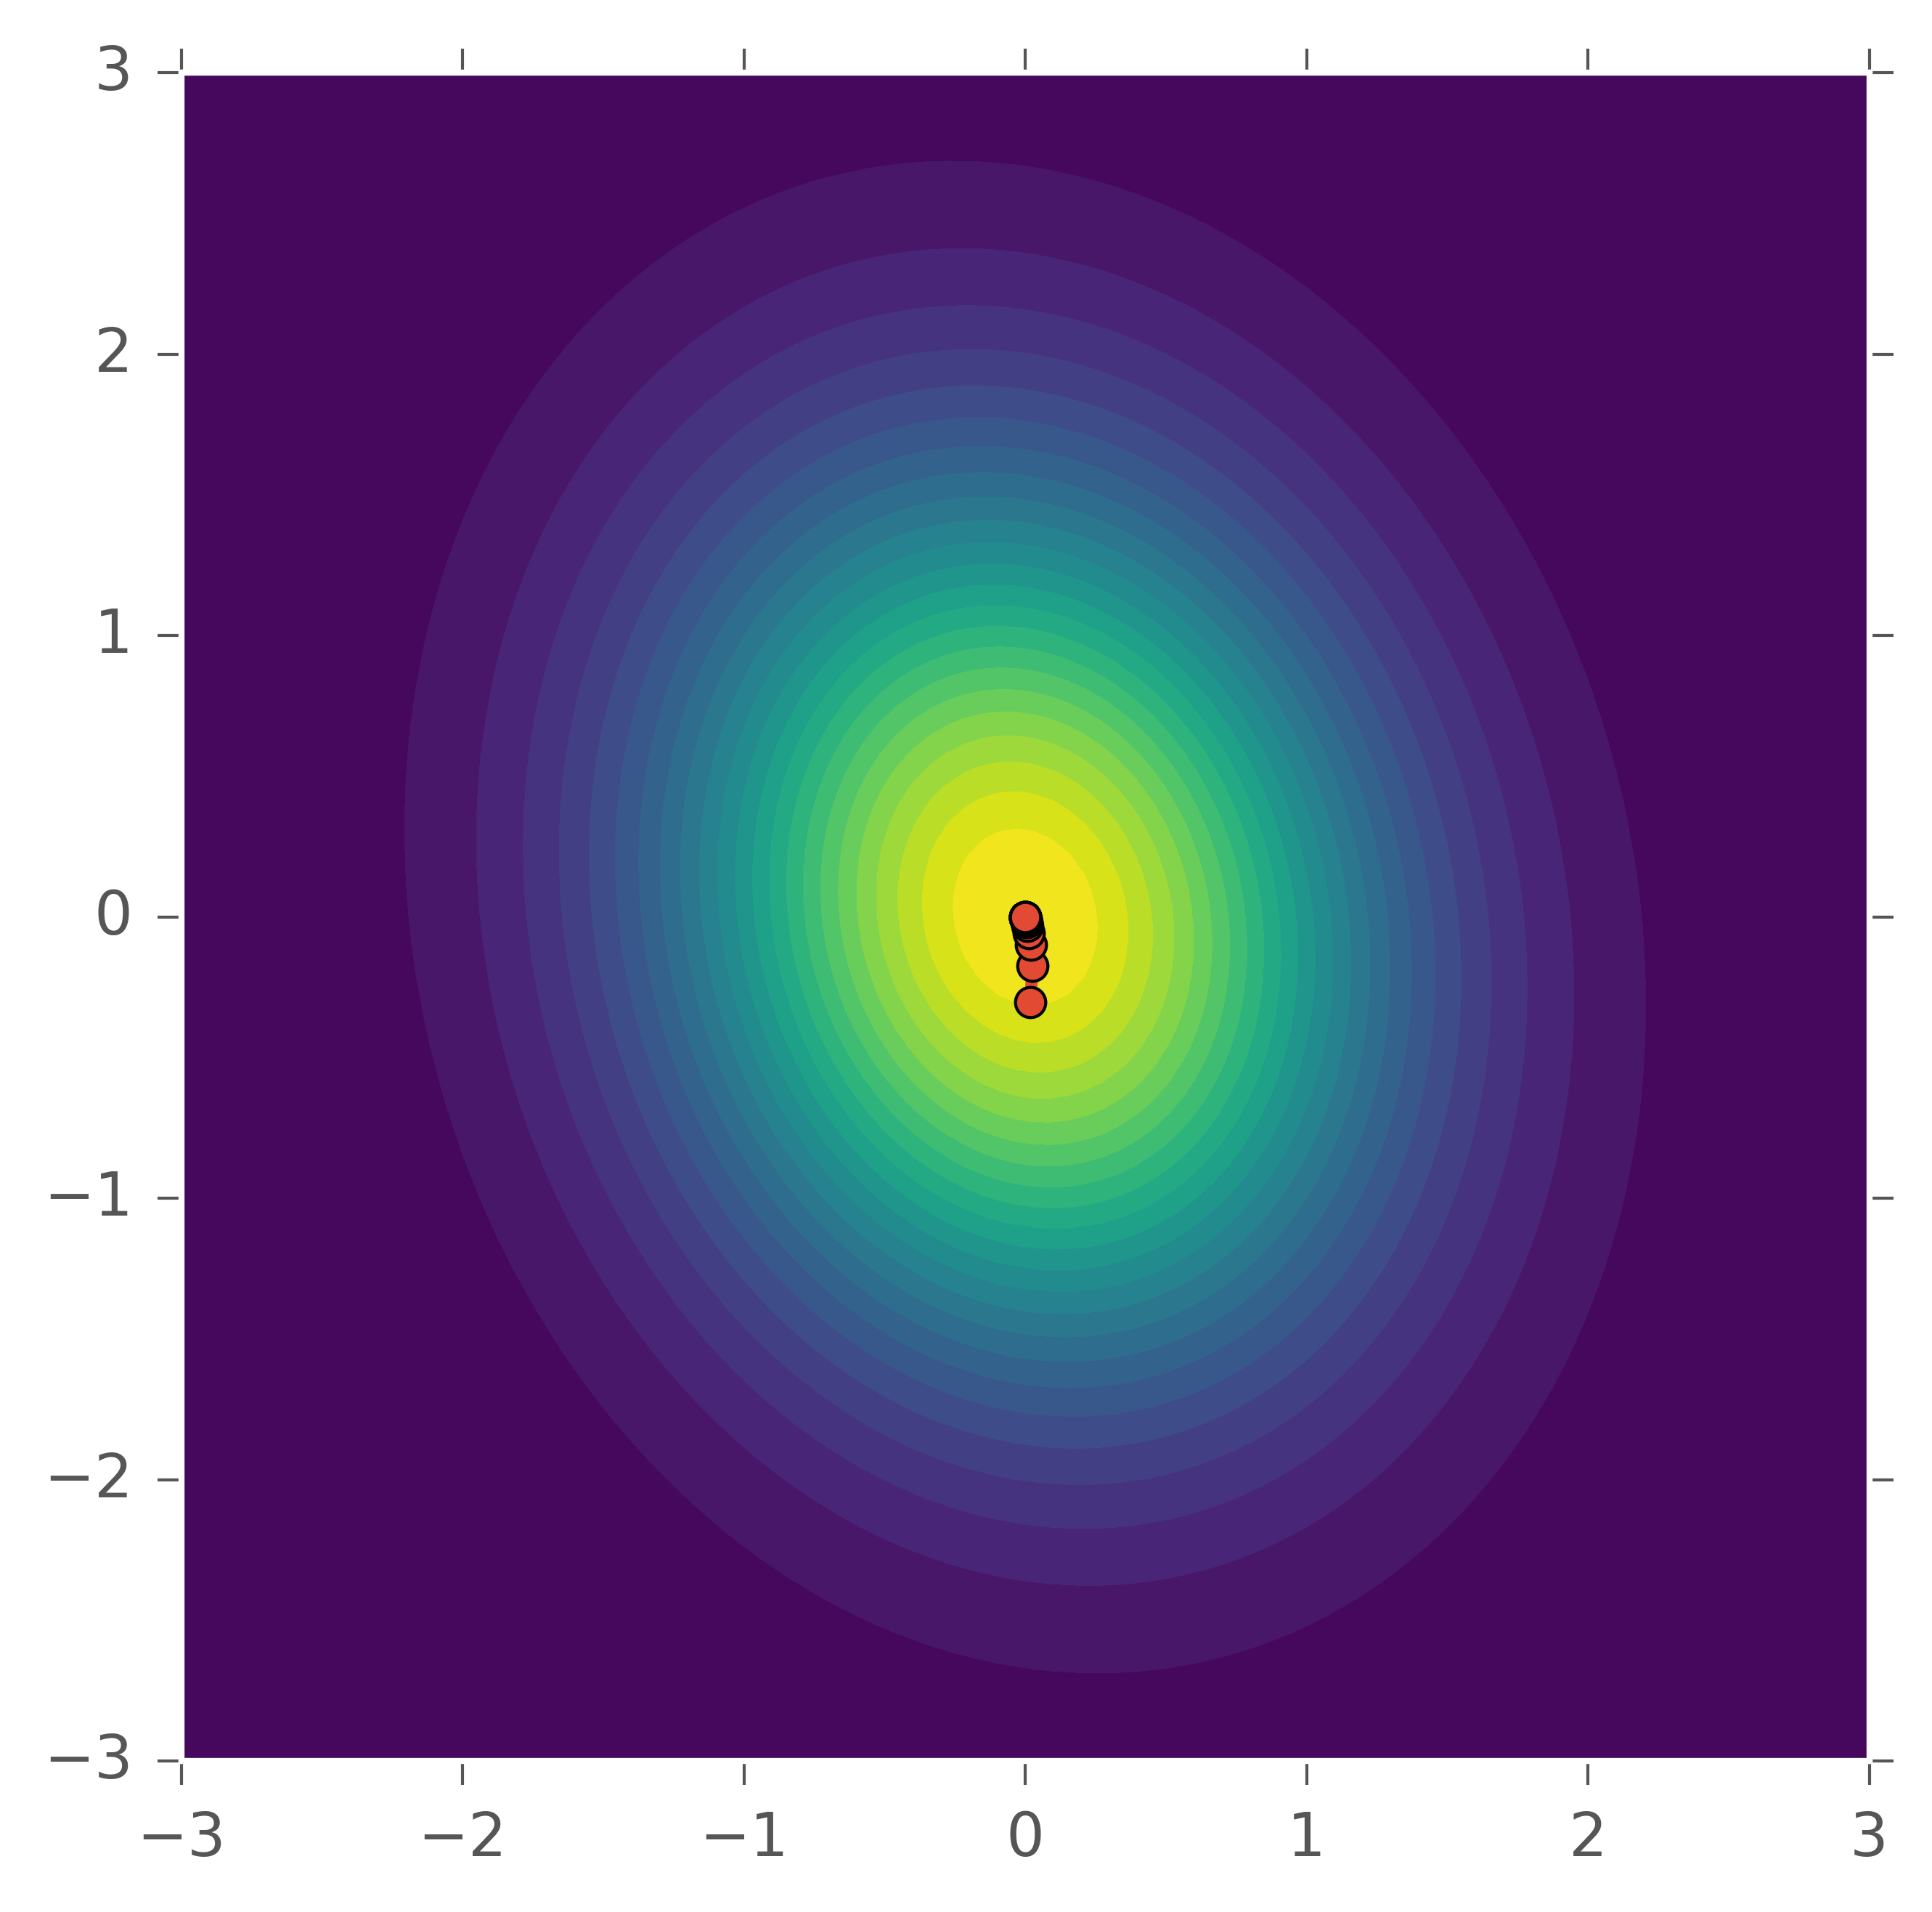

In [114]:
DIM = 2
MU = np.zeros(DIM)
SIGMA = random_psd_matrix(DIM)
STEPS = 30
g, grad_g = np_gaussian_kernel(MU, SIGMA)

pl.figure(0, figsize=(5, 5))

xx, yy = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
coords = np.array([xx.ravel(), yy.ravel()]).T
zz = g(coords).reshape(xx.shape)
pl.contourf(xx, yy, zz, levels=np.linspace(np.min(zz), np.max(zz), 25))

x_init = np.random.randn(DIM)
solution = np_gradient_descent_estimator(grad_g, x_init)
path = np.array(list(islice(solution, STEPS))).T
pl.plot(path[0], path[1], marker='o', markersize=5)

## Theano Manual Gradient descent

In [178]:
def th_gaussian_kernel(mu_v, sigma_v):
    mu = T.constant(mu_v)
    sigma = T.constant(sigma_v)
    
    kernel = lambda x: T.exp(- T.dot((x - mu), T.dot(sigma, (x - mu))))
    grad_kernel = lambda x: - T.dot(sigma, x) * kernel(x)
    return kernel, grad_kernel



In [179]:
def th_gradient_descent_estimator(mu, sigma, steps, x_init, eta=1.0):
    kernel, grad_kernel = th_gaussian_kernel(mu, sigma)
    x = th.shared(x_init)
    grad_kernel = T.grad(kernel(x), x)
    step = th.function([], x, updates=[(x, x + eta * grad_kernel)])

    for _ in range(steps - 1):
        step()
        
    return step()

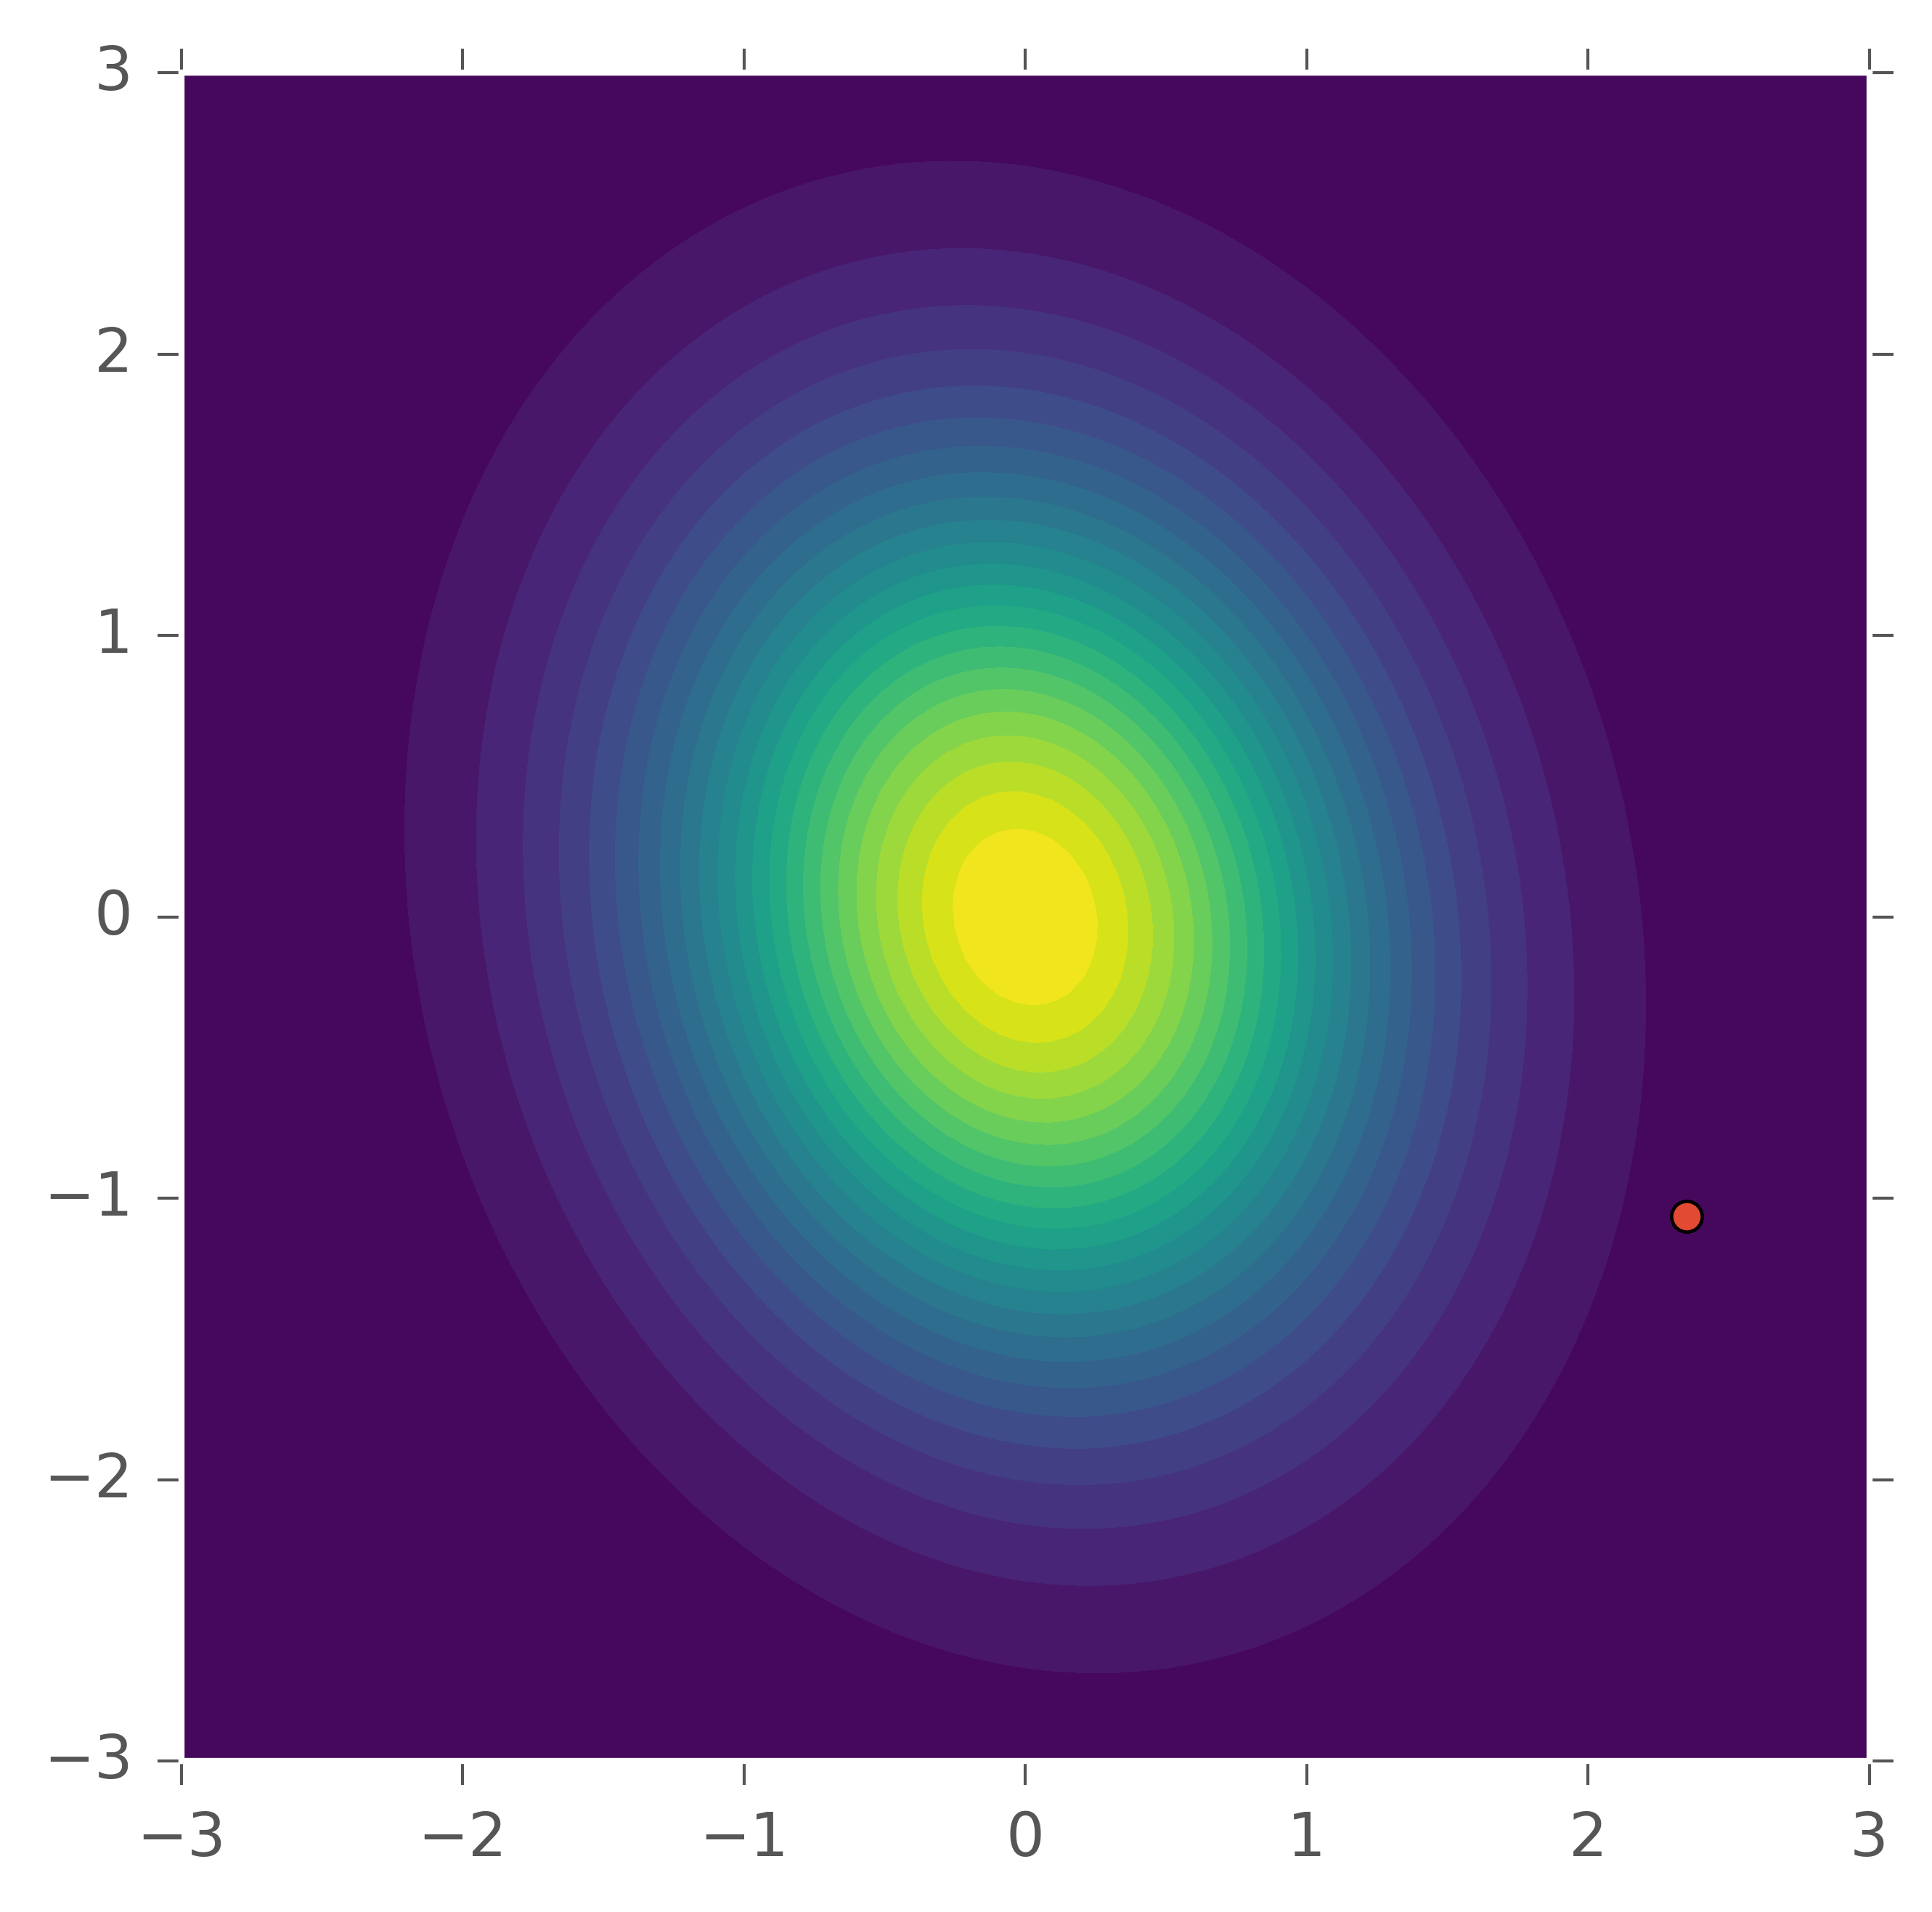

In [180]:
pl.figure(0, figsize=(5, 5))

xx, yy = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
coords = np.array([xx.ravel(), yy.ravel()]).T
zz = g(coords).reshape(xx.shape)
pl.contourf(xx, yy, zz, levels=np.linspace(np.min(zz), np.max(zz), 25))
pl.plot(path[0], path[1], marker='o', markersize=5)

In [202]:
DIM = 5000
MU = np.zeros(DIM)
SIGMA = random_psd_matrix(DIM)
STEPS = 1000

In [203]:
x_init = np.random.randn(DIM)
grad_g = lambda x: - np.dot(SIGMA, x) * np.exp(-np.dot(x, np.dot(SIGMA, x)))

solution = np_gradient_descent_estimator(grad_g, x_init)
result_np = list(islice(solution, STEPS))[-1]

In [204]:
%%time

solution = np_gradient_descent_estimator(grad_g, x_init)
result_np = list(islice(solution, STEPS))[-1]

CPU times: user 55.5 s, sys: 470 ms, total: 55.9 s
Wall time: 29.5 s


In [205]:
%%time

result_th = th_gradient_descent_estimator(MU, SIGMA, STEPS, x_init)

CPU times: user 56.5 s, sys: 950 ms, total: 57.5 s
Wall time: 31 s


In [190]:
result_th - result_np

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])